In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
train_dir = r'C:\Users\ZaZa\Desktop\CancelCell\archive (3)\train'
test_dir = r'C:\Users\ZaZa\Desktop\CancelCell\archive (3)\test'
batch_size = 64
image_size = (224, 224) 
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1,
    zoom_range=0.1, 
    horizontal_flip=True, 
    fill_mode='nearest') 
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True, 
    fill_mode='nearest') 
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create generators for loading images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

# For test data, you can apply minimal augmentation or none at all
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# show the images in the train directory:

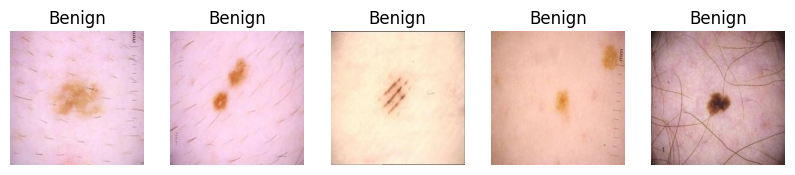

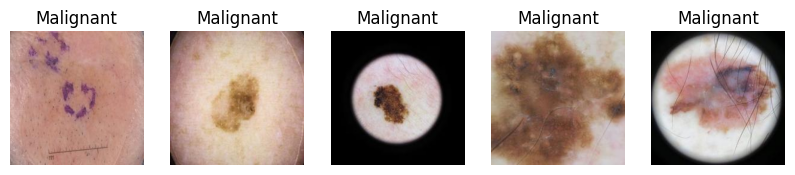

In [3]:
import matplotlib.pyplot as plt

# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = test_generator.class_indices

# Inverse mapping of class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]
    
    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()

# show the images in the train directory:

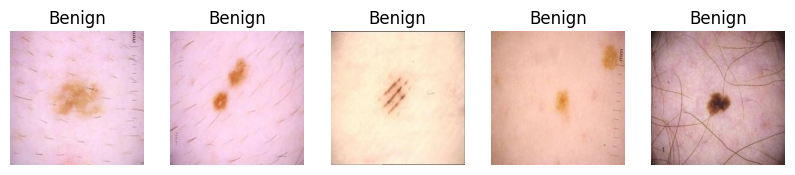

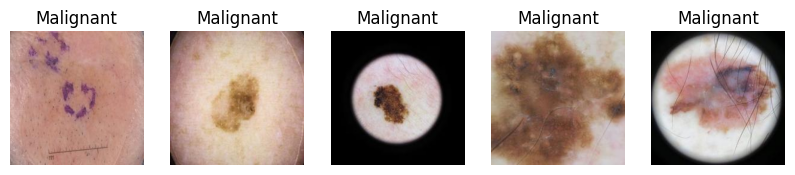

In [4]:
import matplotlib.pyplot as plt

# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = train_generator.class_indices

# Inverse mapping of class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]
    
    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()

# build the model:

In [7]:
from keras.applications import ResNet50
from keras.layers import BatchNormalization


input_shape = (224, 224, 3)

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in resnet_model.layers:
    layer.trainable = False
model = tf.keras.models.Sequential([
    resnet_model,
    BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax') 
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ ?                           │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

# train the model:

In [8]:
import matplotlib.pyplot as plt

# Train the model and store the training history
history1 = model.fit(train_generator, epochs=50, validation_data=test_generator)

# Plot training and testing accuracy

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 147s 772ms/step - accuracy: 0.6996 - loss: 0.6142 - val_accuracy: 0.5005 - val_loss: 1.1525
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 139s 749ms/step - accuracy: 0.7765 - loss: 0.4771 - val_accuracy: 0.7830 - val_loss: 0.5243
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 140s 751ms/step - accuracy: 0.8096 - loss: 0.4266 - val_accuracy: 0.7930 - val_loss: 0.4624
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 140s 750ms/step - accuracy: 0.8163 - loss: 0.4078 - val_accuracy: 0.7770 - val_loss: 0.4454
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 139s 749ms/step - accuracy: 0.8184 - loss: 0.3980 - val_accuracy: 0.8070 - val_loss: 0.4150
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 139s 749ms/step - accuracy: 0.8278 - loss: 0.3820 - val_accuracy: 0.7835 - val_loss: 0.4188
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 140s 749ms/step - accuracy: 0.8302 - loss: 0.3751 - val_accuracy: 0.7730 - val_loss: 0.4352
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 139s 748ms/step - accuracy: 0.8385 -

 # test the trainable model:

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 652ms/step - accuracy: 0.8976 - loss: 0.2703
Test Accuracy: 0.8914999961853027


# plot the loss in each epoch

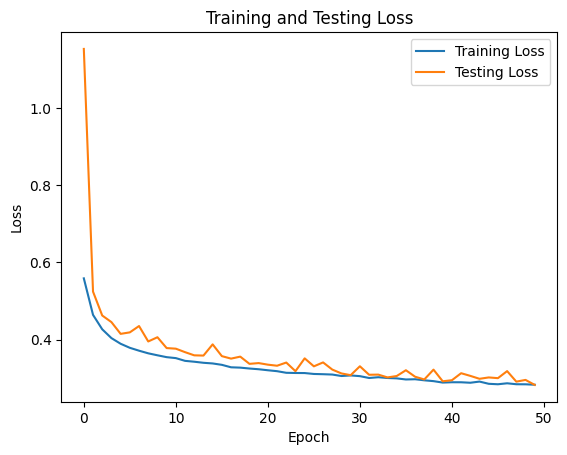

In [10]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

plot the accuracy in each epoch

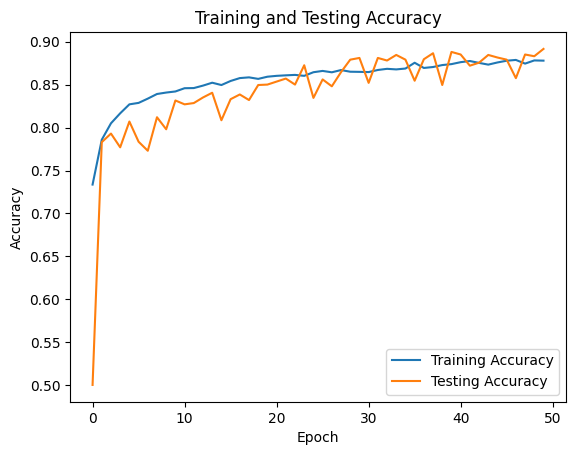

In [11]:
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

## confusion matric and classification report:

In [12]:
predictions = model.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print('----------------------------------------------------------------------------------------------')

class_report = classification_report(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 645ms/step
Confusion Matrix:
[[483 517]
 [524 476]]
----------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.48      0.48      1000
           1       0.48      0.48      0.48      1000

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.48      0.48      0.48      2000



### plot the confusion matrix :

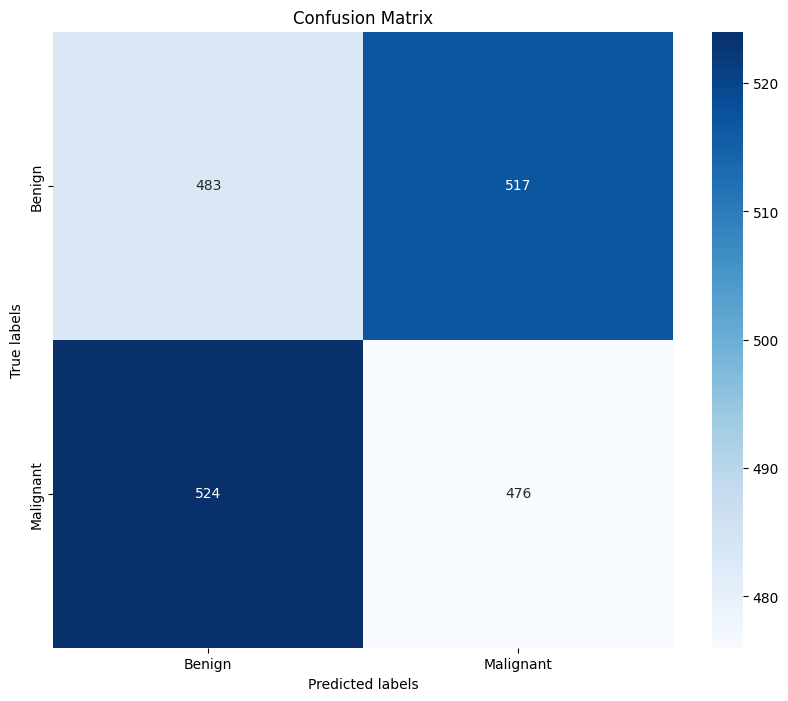

In [13]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


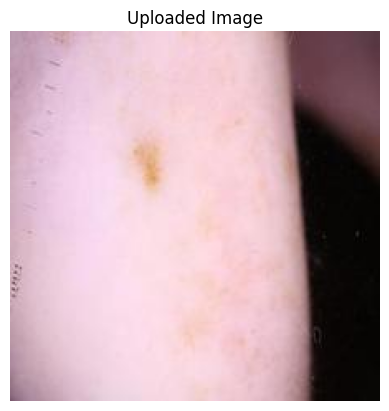

The model predicts that the cancer cell in the uploaded image is type A (Benign).


In [23]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing import image as keras_image

# Function to preprocess the uploaded image
def preprocess_image(image_path):
    # Load the image using PIL
    img = Image.open(image_path)
    # Resize the image to match the input shape of your model
    img = img.resize((224, 224))
    # Convert the image to a numpy array
    img_array = keras_image.img_to_array(img)
    # Expand the dimensions to create a batch of 1 image
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the pixel values to the range [0, 1]
    img_array = img_array / 255.0
    return img, img_array

# Function to make predictions using the model
def predict_image(model, image_path):
    # Preprocess the uploaded image
    original_image, processed_image = preprocess_image(image_path)
    # Make predictions using the model
    predictions = model.predict(processed_image)
    return original_image, predictions

# Path to the uploaded image
uploaded_image_path = r'C:\Users\ZaZa\Desktop\CancelCell\archive (3)\test\Benign\6363.jpg'

# Make predictions using the model
original_image, predictions = predict_image(model, uploaded_image_path)

# Display the uploaded image
plt.imshow(original_image)
plt.axis('off')
plt.title('Uploaded Image')
plt.show()

# Display the prediction result
if predictions[0][0] > predictions[0][1]:
    print("The model predicts that the cancer cell in the uploaded image is type A (Benign).")
else:
    print("The model predicts that the cancer cell in the uploaded image is type B (Malignant).")



In [18]:
class_indices = test_generator.class_indices
print(class_indices)


{'Benign': 0, 'Malignant': 1}
